## Load libraries

In [8]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import geopandas as geopd # podria ser conflictivo
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
import cv2
currentDir = os.path.abspath(os.getcwd())
sys.path.append(os.path.join(currentDir, "general_utils"))
import file_management
from other_utils import geodesic_distance

## Load dataset

In [10]:
metadata_df = file_management.load_pickle('Processed Data/metadata_df.pkl')
pan_shape = metadata_df['original_shape']
df = file_management.load_pickle('Processed Data/dataset.pkl')
df, pan_shape

(                 C           B          G          Y          R         RE  \
 0       107.657256  105.357193  97.342775  88.541732  95.685622  89.459027   
 1        91.784712   90.587493  83.710526  75.313386  82.156806  76.768693   
 2        83.503385   82.710320  76.681398  67.729134  75.269409  70.345190   
 3        84.193495   85.336044  78.811437  66.670866  77.237237  72.381910   
 4        81.433053   84.351398  77.746417  62.437795  76.253323  71.598556   
 ...            ...         ...        ...        ...        ...        ...   
 781331  104.206703   77.787087  63.475157  53.618898  38.372640  67.525115   
 781332   97.650652   74.504931  61.771126  50.267717  36.158834  68.151798   
 781333   92.474823   72.207422  60.919111  48.327559  35.174920  68.621811   
 781334   89.714380   70.894560  60.493103  46.740157  33.945028  68.465140   
 781335   91.094601   72.207422  61.558122  47.269291  34.682963  70.501860   
 
                  N         N2    NDVI_1    NDVI_2

## Trees segmentation

In [11]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from collections import Counter

In [12]:
# Firstly we extract the positional data from the Dataframe
pan_shape = metadata_df['original_shape'] 
lats = df['Lats']
longs = df['Longs']
df = df.iloc[:, :-2]
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,SAVI_6,NPQI_1,NPQI_2,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1
0,107.657256,105.357193,97.342775,88.541732,95.685622,89.459027,104.274182,74.274037,0.042951,-0.125980,...,-0.250487,0.010798,0.013481,0.016159,0.018830,0.021494,0.165608,0.071206,-0.005166,0.888799
1,91.784712,90.587493,83.710526,75.313386,82.156806,76.768693,90.458675,64.378593,0.048095,-0.121324,...,-0.241003,0.006565,0.008195,0.009820,0.011441,0.013058,0.178328,0.080613,-0.000712,0.895103
2,83.503385,82.710320,76.681398,67.729134,75.269409,70.345190,84.702214,59.954747,0.058965,-0.113254,...,-0.224845,0.004771,0.005955,0.007136,0.008312,0.009486,0.204094,0.104599,0.011898,0.901394
3,84.193495,85.336044,78.811437,66.670866,77.237237,72.381910,90.787616,63.680091,0.080645,-0.096206,...,-0.191057,-0.006740,-0.008412,-0.010080,-0.011742,-0.013400,0.254286,0.151960,0.030953,0.917378
4,81.433053,84.351398,77.746417,62.437795,76.253323,71.598556,94.077022,65.309929,0.104642,-0.077304,...,-0.153523,-0.017603,-0.021971,-0.026325,-0.030667,-0.034995,0.313951,0.210050,0.054507,0.936393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.396989,0.145168,0.181211,0.217155,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.473595,0.134447,0.167814,0.201086,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.515550,0.123070,0.153604,0.184046,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.549930,0.117178,0.146245,0.175221,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368


In [13]:
img_gray = np.copy(df.loc[:,'NDVI_1'].values).reshape(pan_shape)
thresh = threshold_otsu(img_gray)
print("threshold: ", thresh)
binary_clear = img_gray > thresh
label_image = label(binary_clear)
regions = regionprops(label_image)
trees = np.zeros_like(binary_clear)
for region in regions:
    # if region.area > 200:
    #     continue
    # if region.perimeter**2 / region.area > 25:
    #     print('perimeter', region.perimeter**2 / region.area)
    #     continue
    # if region.extent < 0.4:
    #     print('extent', region.extent)
    #     continue
    # if region.eccentricity < 0.5:
    #     print('eccentricity', region.eccentricity)
    #     continue

    trees[label_image == region.label] = 1

trees = trees.astype('uint8')
print(Counter(trees.astype('uint8').flatten()))

threshold:  0.17793779025596856
Counter({0: 633172, 1: 148164})


## Apply the watershed algorithm to the binary mask

In [14]:
distance = ndi.distance_transform_edt(trees.astype('uint8'))
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=trees)
print('Initial number of trees: %d' % coords.shape[0])
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=trees)
print('Final number of trees: %d' % np.unique(labels).shape[0])

Initial number of trees: 4034
Final number of trees: 2448


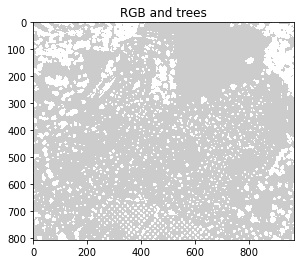

In [15]:
rgb_df = (255*(df/df.max())).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))
# plt.imshow(rgb)
# include the trees in the image
plt.imshow(trees, cmap=plt.cm.gray, interpolation='none', alpha=0.2)
plt.title('RGB and trees')
plt.savefig(os.path.join('Images', 'Trees_segmentation_imagery', 'output.png'), dpi=300, transparent=True)

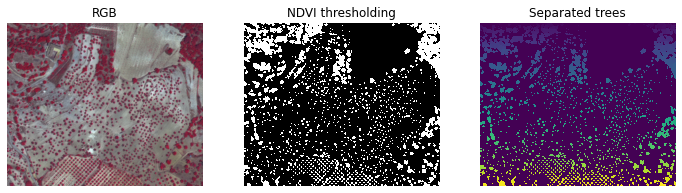

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
ax = axes.ravel()

rgb_df = (255*(df/df.max())).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))
ax[0].imshow(rgb)
# include the trees in the image
# ax[0].imshow(trees, cmap=plt.cm.gray, interpolation='none', alpha=0.3)
ax[0].set_title('RGB')

im=ax[1].imshow(trees, cmap=plt.cm.gray, interpolation='none')
# fig.colorbar(im, ax=ax[1])
ax[1].set_title('NDVI thresholding')

# im = ax[2].imshow(-distance, cmap=plt.cm.gray, interpolation='none')
# # fig.colorbar(im, ax=ax[2])
# ax[2].set_title('Distances')

im = ax[2].imshow(labels, interpolation='none')
# fig.colorbar(im, ax=ax[3])
ax[2].set_title('Separated trees')

for a in ax:
    a.set_axis_off()

# fig.tight_layout()
plt.savefig(os.path.join('Images', 'Trees_segmentation_imagery', 'new_workflow_subplots.png'), dpi=300, transparent=True)
plt.show()

In [17]:
# Assign the labels to the dataframe and include the geographic information
cluster_id = labels.ravel() - 1
df['cluster_id'] = cluster_id
df.loc[df['cluster_id']==-1, 'cluster_id'] = 65535 # background label
df['Lats'] = lats
df['Longs'] = longs
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs
0,107.657256,105.357193,97.342775,88.541732,95.685622,89.459027,104.274182,74.274037,0.042951,-0.125980,...,0.016159,0.018830,0.021494,0.165608,0.071206,-0.005166,0.888799,65535,39.618415,2.581034
1,91.784712,90.587493,83.710526,75.313386,82.156806,76.768693,90.458675,64.378593,0.048095,-0.121324,...,0.009820,0.011441,0.013058,0.178328,0.080613,-0.000712,0.895103,65535,39.618415,2.581040
2,83.503385,82.710320,76.681398,67.729134,75.269409,70.345190,84.702214,59.954747,0.058965,-0.113254,...,0.007136,0.008312,0.009486,0.204094,0.104599,0.011898,0.901394,65535,39.618415,2.581046
3,84.193495,85.336044,78.811437,66.670866,77.237237,72.381910,90.787616,63.680091,0.080645,-0.096206,...,-0.010080,-0.011742,-0.013400,0.254286,0.151960,0.030953,0.917378,65535,39.618415,2.581052
4,81.433053,84.351398,77.746417,62.437795,76.253323,71.598556,94.077022,65.309929,0.104642,-0.077304,...,-0.026325,-0.030667,-0.034995,0.313951,0.210050,0.054507,0.936393,65535,39.618415,2.581058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.217155,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614759,2.586616
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.201086,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614759,2.586622
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.184046,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614759,2.586628
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.175221,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614759,2.586634


In [18]:
# remove rows with cluster_id == 65535
# df = df[df['cluster_id'] != 65535]
file_management.save_pickle(df, 'QPCR_labelled_df', 'Processed Data')
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs
0,107.657256,105.357193,97.342775,88.541732,95.685622,89.459027,104.274182,74.274037,0.042951,-0.125980,...,0.016159,0.018830,0.021494,0.165608,0.071206,-0.005166,0.888799,65535,39.618415,2.581034
1,91.784712,90.587493,83.710526,75.313386,82.156806,76.768693,90.458675,64.378593,0.048095,-0.121324,...,0.009820,0.011441,0.013058,0.178328,0.080613,-0.000712,0.895103,65535,39.618415,2.581040
2,83.503385,82.710320,76.681398,67.729134,75.269409,70.345190,84.702214,59.954747,0.058965,-0.113254,...,0.007136,0.008312,0.009486,0.204094,0.104599,0.011898,0.901394,65535,39.618415,2.581046
3,84.193495,85.336044,78.811437,66.670866,77.237237,72.381910,90.787616,63.680091,0.080645,-0.096206,...,-0.010080,-0.011742,-0.013400,0.254286,0.151960,0.030953,0.917378,65535,39.618415,2.581052
4,81.433053,84.351398,77.746417,62.437795,76.253323,71.598556,94.077022,65.309929,0.104642,-0.077304,...,-0.026325,-0.030667,-0.034995,0.313951,0.210050,0.054507,0.936393,65535,39.618415,2.581058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.217155,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614759,2.586616
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.201086,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614759,2.586622
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.184046,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614759,2.586628
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.175221,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614759,2.586634


In [19]:
# for col in df.columns:
#     plt.hist(df[col], bins=100, alpha=1, density=True)
#     plt.legend(loc='upper right')
#     plt.title(col)
#     plt.show()

## Save the TIF file (change to GDAL env)

In [1]:
import os
import sys
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
currentDir = os.path.abspath(os.getcwd())
sys.path.append(os.path.join(currentDir, "general_utils"))
import file_management

In [2]:
df = file_management.load_pickle('Processed Data/QPCR_labelled_df.pkl')
src_filename = 'Data/Satellite/Puigpunyent_pansharpened.tif'
src_ds = gdal.Open(src_filename)
geo_transform = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()

In [3]:
# create a new column with 0 or 1 depending on whether the row is a tree or not
df['is_tree'] = np.where(df['cluster_id'] != 65535, 1, 0)
pan_shape = (src_ds.RasterYSize, src_ds.RasterXSize)
array = df['is_tree'].values.reshape(pan_shape)
array

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [4]:
driver = gdal.GetDriverByName('GTiff')
dst_filename = 'Processed Data/trees_mask.tif'
rows, cols = np.shape(array)
dst_ds = driver.Create(dst_filename, cols, rows, 1, gdal.GDT_Float32)
dst_ds.SetGeoTransform(geo_transform)
dst_ds.SetProjection(proj)
gdal_array.BandWriteArray(dst_ds.GetRasterBand(1), array)
src_ds = None
dst_ds = None

## Qpcr labelling

In [1]:
import geopandas as geopd
# qpcr_df = geopd.read_file('Data/QPCR tests/Dataset_pcr_processed_degrees.geojson') 
qpcr_df = geopd.read_file('Data/QPCR tests/rojo_verde_daltonia.geojson') 
# qpcr_df = geopd.read_file('Data/QPCR tests/new_red_green.geojson') 
qpcr_df

,Nom. arbre,Data mostreig,Data analisi,qPCR (Harper),PCR,Ct,geometry
0,1,06/02/2019,06/17/2019,-,1.0,NaN,POINT (2.58260 39.61703)
1,2,06/02/2019,06/17/2019,+,2.0,32.0,POINT (2.58259 39.61712)
2,3,06/02/2019,06/17/2019,+,2.0,34.0,POINT (2.58272 39.61719)
3,4,06/02/2019,06/17/2019,+,2.0,31.0,POINT (2.58276 39.61724)
4,5,06/02/2019,06/17/2019,-,1.0,NaN,POINT (2.58279 39.61728)
...,...,...,...,...,...,...,...
785,799,06/20/2019,07/05/2019,-,1.0,NaN,POINT (2.58547 39.61637)
786,800,06/20/2019,07/05/2019,-,1.0,NaN,POINT (2.58556 39.61631)
787,801,None,None,None,NaN,NaN,POINT (2.58558 39.61593)
788,802,None,None,None,NaN,NaN,POINT (2.58553 39.61586)


In [2]:
from collections import Counter
qpcr_df.dropna(inplace=True, subset=['PCR'])
print('Number of samples: %d' % qpcr_df.shape[0])
print('Number of samples with PCR=1: %d' % qpcr_df[qpcr_df['PCR']==1].shape[0])
print('Number of samples with PCR=0: %d' % qpcr_df[qpcr_df['PCR']==2].shape[0])
# In the TFM they were 477 healthy trees and 272 infected trees

Number of samples: 765
Number of samples with PCR=1: 485
Number of samples with PCR=0: 280


In [22]:
qpcr_df["Lat"] = [item.y for item in qpcr_df["geometry"]]
qpcr_df["Lon"] = [item.x for item in qpcr_df["geometry"]]
qpcr_df = qpcr_df[['Lon', 'Lat', 'PCR']]
qpcr_df = qpcr_df.dropna(axis=0)
qpcr_df

,Lon,Lat,PCR
0,2.582599,39.617031,1.0
1,2.582592,39.617116,2.0
2,2.582715,39.617187,2.0
3,2.582757,39.617241,2.0
4,2.582794,39.617281,1.0
...,...,...,...
782,2.585765,39.616452,1.0
783,2.585681,39.616346,1.0
784,2.585504,39.616412,1.0
785,2.585474,39.616372,1.0


In [23]:
# change the PCR values to 0 and 1
qpcr_df.loc[qpcr_df['PCR']==1, 'PCR'] = 0
qpcr_df.loc[qpcr_df['PCR']==2, 'PCR'] = 1
qpcr_df


,Lon,Lat,PCR
0,2.582599,39.617031,0.0
1,2.582592,39.617116,1.0
2,2.582715,39.617187,1.0
3,2.582757,39.617241,1.0
4,2.582794,39.617281,0.0
...,...,...,...
782,2.585765,39.616452,0.0
783,2.585681,39.616346,0.0
784,2.585504,39.616412,0.0
785,2.585474,39.616372,0.0


In [24]:
infected_trees = qpcr_df.loc[qpcr_df['PCR']==1]
healthy_trees = qpcr_df.loc[qpcr_df['PCR']==0]

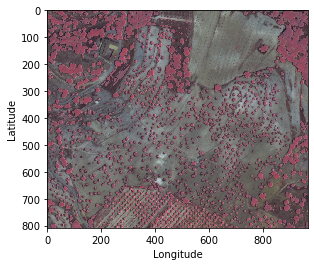

In [25]:
# plt.imshow(df['cluster_id'].values.reshape(pan_shape), interpolation='none', 
#            extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])
df = file_management.load_pickle('Processed Data/QPCR_labelled_df.pkl')
metadata_df = file_management.load_pickle('Processed Data/metadata_df.pkl')
pan_shape = metadata_df['original_shape']
rgb_df = (255*(df/df.max())).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))
# plt.imshow(rgb)
plt.imshow(rgb, interpolation='none') 
        #    extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])
plt.imshow(trees, cmap=plt.cm.gray, interpolation='none', alpha=0.2)
        #    extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])
# plt.xticks(np.linspace(0, 303, 4), np.round(np.linspace(longs.min(), longs.max(), 4), decimals=3))
# plt.yticks(np.linspace(0, 253, 4), np.round(np.linspace(lats.max(), lats.min(), 4), decimals=3))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)
# plt.scatter(infected_trees['Lon'], infected_trees['Lat'], s=1, c='k', alpha=1)
# plt.scatter(healthy_trees['Lon'], healthy_trees['Lat'], s=1, c='white', alpha=1)
# plt.legend(['Infected', 'Healthy'])

path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, 'Tests_layout_binary_mask.png'), dpi=300, transparent=True)

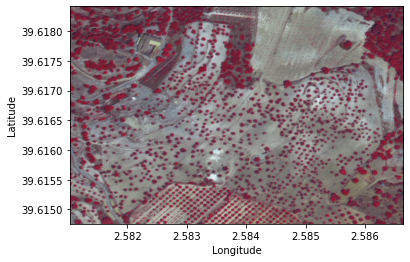

In [26]:
rgb_df = (255*df/df.max()).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))

fig = plt.figure()
plt.imshow(rgb,
          extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)

plt.scatter(infected_trees['Lon'], infected_trees['Lat'], s=(72/300)**2, alpha=1, c='yellow', marker='s')
plt.scatter(healthy_trees['Lon'], healthy_trees['Lat'], s=(72/300)**2, alpha=1, c='indigo', marker='s')

path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, 'Tests_layout_rgb.png'), dpi=300, transparent=True)

In [27]:
# We remove the background label from the dataframe and we create a new column for the PCR results
trees_df = df.loc[df['cluster_id'] != 65535]
df['PCR'] = np.nan

trees_df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs
29,60.384679,58.094153,51.333936,38.450394,42.554274,43.711153,63.485543,38.184771,0.197391,-0.054119,...,0.028877,0.033620,0.038342,0.452388,0.236717,0.044344,0.704720,0,39.618415,2.581203
30,75.912168,70.238129,60.067095,43.741732,45.014058,53.268072,80.919397,49.011551,0.285114,0.042515,...,0.058036,0.067594,0.077119,0.519098,0.347150,0.070663,0.592976,0,39.618415,2.581208
31,77.637444,69.253482,57.937056,41.801575,39.602532,54.991451,84.866684,52.504060,0.363657,0.140072,...,0.085324,0.099376,0.113380,0.543271,0.464808,0.101305,0.510096,0,39.618415,2.581214
32,86.263827,74.833147,61.132115,44.976378,38.864597,62.824991,97.859840,61.817419,0.431490,0.227973,...,0.106104,0.123596,0.141035,0.557658,0.600793,0.133339,0.450532,0,39.618415,2.581220
33,89.714380,75.817793,61.558122,46.034646,36.896769,67.838457,105.589945,67.871102,0.482102,0.295647,...,0.125547,0.146252,0.166894,0.556491,0.715289,0.164117,0.411269,0,39.618415,2.581226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.217155,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614759,2.586616
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.201086,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614759,2.586622
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.184046,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614759,2.586628
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.175221,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614759,2.586634


In [28]:
df0 = df.copy()

In [29]:
df = df0.copy()

# Asociate each tree to the closest QPCR test
trees_lons = trees_df['Longs'].values
trees_lats = trees_df['Lats'].values

qpcr_lons = qpcr_df['Lon'].values
qpcr_lats = qpcr_df['Lat'].values
qpcr_results = qpcr_df['PCR'].values

min_list = []

n_pcr = len(qpcr_lons)
n_else = 0
n_else0 = 0
cluster_to_pcr_dist = {}
for lon, lat, pcr in zip(qpcr_lons, qpcr_lats, qpcr_results):
    # Find the closest tree to the QPCR test
    distance_to_trees = geodesic_distance(lon, lat, trees_lons, trees_lats)
    index_min = np.argmin(distance_to_trees)
    min_dist = np.min(distance_to_trees)
    # Check if the distance is less than 3m
    if min_dist < 3: 
        min_list.append(min_dist)
        idx = trees_df.index[index_min]
        cluster_idx = trees_df.loc[idx, 'cluster_id']
        if pcr == 1:
            if np.all(np.isnan(df.loc[df['cluster_id']==cluster_idx, 'PCR'])):
                # df.loc[idx, 'PCR'] = pcr
                df.loc[df['cluster_id']==cluster_idx, 'PCR'] = pcr
                cluster_to_pcr_dist[cluster_idx] = min_dist
            else:
                n_else0 += 1
                d_old = cluster_to_pcr_dist[cluster_idx]
                if d_old > min_dist:
                    df.loc[df['cluster_id']==cluster_idx, 'PCR'] = np.nan
                    # df.loc[idx, 'PCR'] = pcr
                    df.loc[df['cluster_id']==cluster_idx, 'PCR'] = pcr
                    cluster_to_pcr_dist[cluster_idx] = min_dist
                    
        elif pcr == 0:
            # If the tree has no PCR value, assign the PCR value of the QPCR test
            if np.all(np.isnan(df.loc[df['cluster_id']==cluster_idx, 'PCR'])):
                df.loc[df['cluster_id']==cluster_idx, 'PCR'] = pcr
                # df.loc[idx, 'PCR'] = pcr
                cluster_to_pcr_dist[cluster_idx] = min_dist
            else:
                n_else += 1
                d_old = cluster_to_pcr_dist[cluster_idx]
                if d_old > min_dist:
                    df.loc[df['cluster_id']==cluster_idx, 'PCR'] = np.nan
                    df.loc[df['cluster_id']==cluster_idx, 'PCR'] = pcr
                    # df.loc[idx, 'PCR'] = pcr
                    cluster_to_pcr_dist[cluster_idx] = min_dist

    # if j > 3:
    #     break

In [30]:
file_management.save_pickle(df, 'QPCR_labelled_df_qpcr', 'Processed Data')
print('Number of QPCR tests: ', n_pcr)
print('Number of else: ', n_else0)
print('Number of else: ', n_else)

Number of QPCR tests:  765
Number of else:  6
Number of else:  21


In [1]:
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
# import file_management
import os
import sys
currentDir = os.path.abspath(os.getcwd())
sys.path.append(os.path.join(currentDir, "general_utils"))
import file_management


df = file_management.load_pickle('Processed Data/QPCR_labelled_df_qpcr.pkl')

src_filename = 'Data/Satellite/Puigpunyent_pansharpened.tif'
src_ds = gdal.Open(src_filename)
geo_transform = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()

In [2]:
# create a new column with 0, 1 or 2 depending on whether the row is infected, healthy or unknown
df['PCR_label'] = np.nan
df.loc[df['PCR'] == 1, 'PCR_label'] = 1
df.loc[df['PCR'] == 0, 'PCR_label'] = 0
df.loc[np.isnan(df['PCR']), 'PCR_label'] = 2
pan_shape = (src_ds.RasterYSize, src_ds.RasterXSize)
array = df['PCR_label'].values.reshape(pan_shape)
array

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [3]:
driver = gdal.GetDriverByName('GTiff')
dst_filename = 'Processed Data/QPCR_labelled_df_mask_new.tif'
rows, cols = np.shape(array)
dst_ds = driver.Create(dst_filename, cols, rows, 1, gdal.GDT_Float32)
dst_ds.SetGeoTransform(geo_transform)
dst_ds.SetProjection(proj)
gdal_array.BandWriteArray(dst_ds.GetRasterBand(1), array)
src_ds = None
dst_ds = None

In [54]:
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR,PCR_label
0,107.657256,105.357193,97.342775,88.541732,95.685622,89.459027,104.274182,74.274037,0.042951,-0.125980,...,0.021494,0.165608,0.071206,-0.005166,0.888799,65535,39.618415,2.581034,NaN,2.0
1,91.784712,90.587493,83.710526,75.313386,82.156806,76.768693,90.458675,64.378593,0.048095,-0.121324,...,0.013058,0.178328,0.080613,-0.000712,0.895103,65535,39.618415,2.581040,NaN,2.0
2,83.503385,82.710320,76.681398,67.729134,75.269409,70.345190,84.702214,59.954747,0.058965,-0.113254,...,0.009486,0.204094,0.104599,0.011898,0.901394,65535,39.618415,2.581046,NaN,2.0
3,84.193495,85.336044,78.811437,66.670866,77.237237,72.381910,90.787616,63.680091,0.080645,-0.096206,...,-0.013400,0.254286,0.151960,0.030953,0.917378,65535,39.618415,2.581052,NaN,2.0
4,81.433053,84.351398,77.746417,62.437795,76.253323,71.598556,94.077022,65.309929,0.104642,-0.077304,...,-0.034995,0.313951,0.210050,0.054507,0.936393,65535,39.618415,2.581058,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614754,2.586622,NaN,2.0
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614754,2.586628,NaN,2.0
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614754,2.586634,NaN,2.0
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614754,2.586640,NaN,2.0


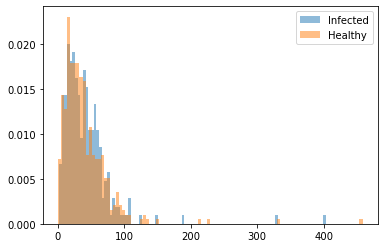

In [31]:
#get the average size in pixels of the infected and healthy trees
infected_trees = df.loc[df['PCR'] == 1]
healthy_trees = df.loc[df['PCR'] == 0]

# groupby cluster_id and count the number of pixels in each cluster
infected_trees = infected_trees.groupby('cluster_id').count()
healthy_trees =healthy_trees.groupby('cluster_id').count()

# plot the histogram for infected and healthy trees
plt.hist(infected_trees['PCR'], bins=100, alpha=0.5, label='Infected', density=True)
plt.hist(healthy_trees['PCR'], bins=100, alpha=0.5, label='Healthy', density=True)
plt.legend(loc='best')

In [32]:
# df.dropna(inplace=True)
# change nan in pcr column
print('Number of samples: %d' % df.shape[0])
print('Number of samples with PCR=0: %d' % df[df['PCR']==0].shape[0])
print('Number of samples with PCR=1: %d' % df[df['PCR']==1].shape[0])

Number of samples: 781336
Number of samples with PCR=0: 17325
Number of samples with PCR=1: 11020


In [33]:
# replace nan values in the PCR column with 0
# df['PCR'] = df['PCR'].fillna(0)
# remove all rows with cluster_id == 65535
df = df.loc[df['cluster_id'] != 65535]
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR
29,60.384679,58.094153,51.333936,38.450394,42.554274,43.711153,63.485543,38.184771,0.197391,-0.054119,...,0.033620,0.038342,0.452388,0.236717,0.044344,0.704720,0,39.618415,2.581203,NaN
30,75.912168,70.238129,60.067095,43.741732,45.014058,53.268072,80.919397,49.011551,0.285114,0.042515,...,0.067594,0.077119,0.519098,0.347150,0.070663,0.592976,0,39.618415,2.581208,NaN
31,77.637444,69.253482,57.937056,41.801575,39.602532,54.991451,84.866684,52.504060,0.363657,0.140072,...,0.099376,0.113380,0.543271,0.464808,0.101305,0.510096,0,39.618415,2.581214,NaN
32,86.263827,74.833147,61.132115,44.976378,38.864597,62.824991,97.859840,61.817419,0.431490,0.227973,...,0.123596,0.141035,0.557658,0.600793,0.133339,0.450532,0,39.618415,2.581220,NaN
33,89.714380,75.817793,61.558122,46.034646,36.896769,67.838457,105.589945,67.871102,0.482102,0.295647,...,0.146252,0.166894,0.556491,0.715289,0.164117,0.411269,0,39.618415,2.581226,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2382,39.614759,2.586616,NaN
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2382,39.614759,2.586622,NaN
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2382,39.614759,2.586628,NaN
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2382,39.614759,2.586634,NaN


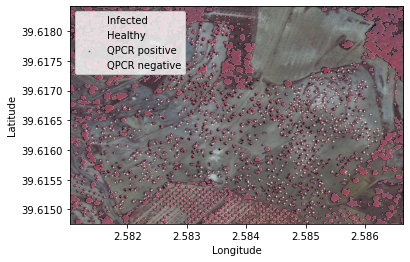

In [36]:
# Plot the trees used for training and testing
original_df = file_management.load_pickle('Processed Data/dataset.pkl')
metadata_df = file_management.load_pickle('Processed Data/metadata_df.pkl')
pan_shape = metadata_df['original_shape']
# Loc three columns of original dataset
original_df = original_df.loc[:, ['N', 'R', 'G', 'Longs', 'Lats']]	
rgb_df = (255*original_df/original_df.max()).astype(np.uint8)
rgb = np.dstack((rgb_df['N'].values.reshape(pan_shape),rgb_df['R'].values.reshape(pan_shape),rgb_df['G'].values.reshape(pan_shape)))
fig = plt.figure()

plt.imshow(rgb,
        extent=[original_df['Longs'].min(), original_df['Longs'].max(), original_df['Lats'].min(), original_df['Lats'].max()])
plt.imshow(trees, cmap=plt.cm.gray, interpolation='none', alpha=0.2,
           extent=[original_df['Longs'].min(), original_df['Longs'].max(), original_df['Lats'].min(), original_df['Lats'].max()])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)
# Draw a circle around the trees used for training and testing 
# get the latitudes for rows with PCR value 0 and 1
lat_train = df.loc[df['PCR']==1]['Lats']
lon_train = df.loc[df['PCR']==1]['Longs']
lat_test = df.loc[df['PCR']==0]['Lats']
lon_test = df.loc[df['PCR']==0]['Longs']
plt.scatter(lon_train, lat_train, s=0.1, alpha=0.01, c='red')
plt.scatter(lon_test, lat_test, s=0.1, alpha=0.01, c='green')

# scatter the test data for the QPCR tests differenciating between positive and negative
lat_test = qpcr_df.loc[qpcr_df['PCR']==1]['Lat']
lon_test = qpcr_df.loc[qpcr_df['PCR']==1]['Lon']
#scatter the test data for the QPCR tests with a star marker 
plt.scatter(lon_test, lat_test, s=0.5, alpha=0.5, c='k')
lat_test = qpcr_df.loc[qpcr_df['PCR']==0]['Lat']
lon_test = qpcr_df.loc[qpcr_df['PCR']==0]['Lon']
plt.scatter(lon_test, lat_test, s=0.5, alpha=0.5, c='white')

plt.legend(['Infected', 'Healthy', 'QPCR positive', 'QPCR negative'])
plt.savefig(os.path.join(path, 'Tests_layout_rgb2.png'), dpi=300, transparent=True)

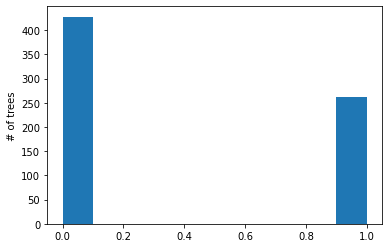

In [37]:
# Remove the trees that have no PCR value
classified_trees_df = df.dropna(axis=0)

# Plot the number of trees per PCR value
classified_trees_df.groupby('cluster_id').mean()['PCR'].hist()
plt.grid(False)
plt.ylabel('# of trees')
path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, '#_trees_per_QPCR_class.png'), dpi=300, transparent=True)

41.07971014492754 37.99394719036691 458 1


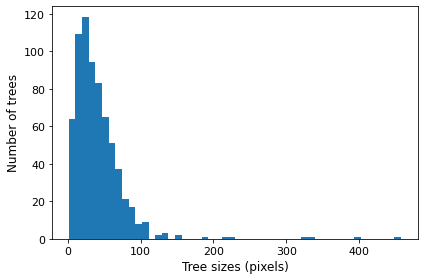

In [38]:
## Explore the size in pixels of the trees
tree_sizes = classified_trees_df.groupby('cluster_id')['cluster_id'].count().values

fig, ax = plt.subplots()
# the histogram of the data
num_bins = 50
n, bins, patches = ax.hist(tree_sizes, num_bins)

ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_ylabel('Number of trees', fontsize=12)
ax.set_xlabel('Tree sizes (pixels)', fontsize=12)
print(np.mean(tree_sizes), np.std(tree_sizes), np.max(tree_sizes), np.min(tree_sizes))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, '#_pixels_per_tree_and_QPCR_class.png'), dpi=300, transparent=True)

ValueError: cannot reshape array of size 148161 into shape (808,967)

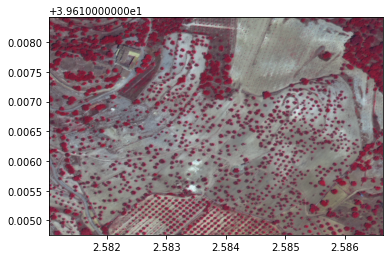

In [39]:
from matplotlib.lines import Line2D

plt.imshow(rgb,
          extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()])

plt.imshow(df['PCR'].values.reshape(pan_shape), interpolation='none', 
           extent=[df['Longs'].min(), df['Longs'].max(), df['Lats'].min(), df['Lats'].max()], alpha=0.5)
# plt.colorbar(label='Cluster id')
legend_elements = [Line2D([0], [0], marker='s', color='yellow', linestyle='None', label='Negatives', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='s', color='indigo', linestyle='None', label='Positives', markerfacecolor='indigo', markersize=10)]
plt.legend(handles=legend_elements, loc='upper left')

# plt.xticks(np.linspace(0, 303, 4), np.round(np.linspace(longs.min(), longs.max(), 4), decimals=3))
# plt.yticks(np.linspace(0, 253, 4), np.round(np.linspace(lats.max(), lats.min(), 4), decimals=3))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ticklabel_format(useOffset=False)

path = 'Images/QPCR_test_imagery'
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, 'Trees_QPCR_label.png'), dpi=300, transparent=True)